# Marina Lebedina
## ID: 12249127

# HW 4. Financial Ratio Quantile Strategies

### Period: January 2012 - January 2019

# 1. Process data and calculate daily ratios $\frac{D}{E}$, $\frac{P}{E}$, $ROI$

$$ DE = \frac{D}{E} = \frac{\text{Total Debt}}{\text{Mkt Cap}} $$

$$ PE = \frac{P}{E} = \frac{\text{Mkt Cap}}{\text{Net Income}} = \frac{\text{Price}}{\text{EPS (diluted/basic)}} $$

$$ ROI = \frac{\text{Operating Income}}{\text{Mkt Cap + LT Debt (net/total)}} $$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from tqdm import tnrange
from pandas.tseries.offsets import BDay
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')
quandl.ApiConfig.api_key = 'bWbMQmPczynWg63DzkA9'

In [2]:
def get_data(ticker):

    qs = ['{}-03-31', 
          '{}-06-30', 
          '{}-09-30', 
          '{}-12-31']
    years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

    periods = []

    for i in range(len(years)):
        year = years[i]
        for j in range(len(qs)):
            period = qs[j].format(year)
            periods.append(period)
            
    stat = pd.DataFrame(index=periods[3:], columns=['ticker', 'per_type', 
                        'filing_date', 'shares_out', 'tot_debt_tot_equity', 'ret_invst', 
                        'tot_lterm_debt', 'net_lterm_debt', 'eps_diluted_net', 'basic_net_eps'])

    data_sh = quandl.get_table('ZACKS/SHRS', ticker=ticker, paginate=True, 
                    qopts={'columns':['shares_out', 'per_end_date']}, per_end_date=periods)
    data_sh = data_sh.set_index('per_end_date')

    data_fr = quandl.get_table('ZACKS/FR', ticker=ticker, paginate=True, 
                    qopts={'columns':['per_end_date','tot_debt_tot_equity','ret_invst']}, per_end_date=periods)
    data_fr = data_fr.set_index('per_end_date')

    data_fc = quandl.get_table('ZACKS/FC', ticker=ticker, paginate=True, 
                    qopts={'columns':['ticker', 'per_end_date', 'per_type', 'tot_lterm_debt', 'net_lterm_debt',
                           'eps_diluted_net', 'basic_net_eps', 'filing_date']}, per_end_date=periods)
    data_fc = data_fc.set_index('per_end_date')
    
    for i in tnrange(3, len(periods), desc='Extracting features from Zacks'):
        
        period = periods[i]

        stat.loc[period, 'ticker']              = data_fc.loc[period, 'ticker'][0]
        stat.loc[period, 'per_type']            = data_fc.loc[period, 'per_type'][0]
        stat.loc[period, 'filing_date']         = data_fc.loc[period, 'filing_date'][0]
        stat.loc[period, 'tot_lterm_debt']      = data_fc.loc[period, 'tot_lterm_debt'][0]
        stat.loc[period, 'net_lterm_debt']      = data_fc.loc[period, 'net_lterm_debt'][0]
        stat.loc[period, 'eps_diluted_net']     = data_fc.loc[period, 'eps_diluted_net'][0]
        stat.loc[period, 'basic_net_eps']       = data_fc.loc[period, 'basic_net_eps'][0]

        stat.loc[period, 'tot_debt_tot_equity'] = data_fr.loc[period, 'tot_debt_tot_equity'][0]
        stat.loc[period, 'ret_invst']           = data_fr.loc[period, 'ret_invst'][0]

        stat.loc[period, 'shares_out']          = data_sh.loc[period, 'shares_out'][0]
    
    stat['filing_date'] = pd.to_datetime(stat['filing_date'])
    stat.index = pd.to_datetime(stat.index)
    
    return stat


def calc_ratios(ticker, stat, start, end):
    
    data_p = quandl.get('EOD/{}'.format(ticker), start_date=start, end_date=end)
    prices1 = data_p[['Adj_Close']]
    prices = prices1.loc['2012-01-01':'2020-01-01'].reset_index()

    stat['DE_Debt'] = np.nan
    stat['OI'] = np.nan
    stat['NI'] = np.nan
    prices['DE_ratio'] = np.nan
    prices['ROI_ratio'] = np.nan
    prices['PE_ratio'] = np.nan

    for i in tnrange(prices.shape[0], desc='Calculating ratios'):
#     for i in range(prices.shape[0]):

        timestamp = prices['Date'][i]
        price = prices['Adj_Close'][i]
        
        ref_pull = stat.iloc[abs(timestamp - stat['filing_date']).argsort()[:2]]

        if pd.to_datetime(ref_pull['filing_date'][0]) < pd.to_datetime(timestamp):
            ref_date = ref_pull.index[0]
        else:
            ref_date = ref_pull.index[1]

        if date.weekday(pd.to_datetime(ref_date)) == 5:
            bday = pd.to_datetime(ref_date) - timedelta(days=1)
        elif date.weekday(pd.to_datetime(ref_date)) == 6:
            bday = pd.to_datetime(ref_date) - timedelta(days=2)
        else:
            bday = pd.to_datetime(ref_date)

    #         if bday != prices1.iloc[abs(prices1.index - bday).argsort()[:1]].index[0]:
    #             print(ref_date, bday, prices1.iloc[abs(prices1.index - bday).argsort()[:1]].index[0])

        ref_adj_close = prices1.iloc[abs(prices1.index - bday).argsort()[:1]]['Adj_Close'][0]
        adj_mktv = stat.loc[ref_date, 'shares_out'] * ref_adj_close

        curr_mktv = price * stat.loc[ref_date, 'shares_out']

        # Calculate Total Debt, OI, NI
        stat.loc[ref_date, 'DE_Debt'] = adj_mktv * stat.loc[ref_date, 'tot_debt_tot_equity']

        if np.isnan(stat.loc[ref_date, 'net_lterm_debt']) == False:
            stat.loc[ref_date, 'OI'] = stat.loc[ref_date, 'ret_invst'] * (adj_mktv + stat.loc[ref_date, 'net_lterm_debt'])
        else:
            stat.loc[ref_date, 'OI'] = stat.loc[ref_date, 'ret_invst'] * (adj_mktv + stat.loc[ref_date, 'tot_lterm_debt'])

        if np.isnan(stat.loc[ref_date, 'eps_diluted_net']) == False:
            stat.loc[ref_date, 'NI'] = stat.loc[ref_date, 'eps_diluted_net'] * stat.loc[ref_date, 'shares_out']
        else:
            stat.loc[ref_date, 'NI'] = stat.loc[ref_date, 'basic_net_eps'] * stat.loc[ref_date, 'shares_out']

        # Calculate the ratios
        de_ratio = stat.loc[ref_date, 'DE_Debt'] / curr_mktv
        if np.isnan(stat.loc[ref_date, 'net_lterm_debt']) == False:
            roi_ratio = stat.loc[ref_date, 'OI'] / (curr_mktv + stat.loc[ref_date, 'net_lterm_debt'])
        else:
            roi_ratio = stat.loc[ref_date, 'OI'] / (curr_mktv + stat.loc[ref_date, 'tot_lterm_debt'])
        pe_ratio = curr_mktv / stat.loc[ref_date, 'NI'] 

        if np.isnan(de_ratio) == True or np.isnan(roi_ratio) == True or np.isnan(pe_ratio) == True:
            print('is NaN')
        #   print('DE_Debt = {}'.format(stat.loc[ref_date, 'DE_Debt']))
        #   print('OI = {}'.format(stat.loc[ref_date, 'OI']))
        #   print('NI = {}'.format(stat.loc[ref_date, 'NI']))
        #   print('Curr mktv = {}'.format(curr_mktv))
        #   print('Net LT Debt = {}'.format(stat.loc[ref_date, 'net_lterm_debt']))
        #   print('Tot LT Debt = {}'.format(stat.loc[ref_date, 'tot_lterm_debt']))

        prices.loc[i, 'DE_ratio'] = de_ratio
        prices.loc[i, 'ROI_ratio'] = roi_ratio
        prices.loc[i, 'PE_ratio'] = pe_ratio

    return prices, stat

In [3]:
# tckr = 'LLY'
# s_df_ = get_data(tckr)
# p_df, s_df = calc_ratios(tckr, s_df_, '2011-09-01', '2020-01-01')

# p_df[p_df['Date'] == '2017-10-30']

In [4]:
# 5 - auto-tires trucks
# 15 - transportation
# 13 - finance
# 16 - business services

tckr_pull = pd.read_csv('http://static.quandl.com/zacks/zacks-tickers.csv', header=None, skiprows=1,
                       names=['Ticker', "Comp_name"])
tckrs_np = tckr_pull['Ticker']

tckr_ok = []

for i in tnrange(tckr_pull.shape[0]):
    ticker = tckr_pull['Ticker'][i]
    data = quandl.get_table('ZACKS/FC', paginate=True, ticker=ticker, per_end_date='2011-09-30',
                    qopts={'columns':['ticker', 'per_end_date', 'per_type', 
                                      'zacks_sector_code']})
    if data['zacks_sector_code'].empty == False:
        if data['zacks_sector_code'][0] not in (5, 13, 15, 16):
            try:
                prices = quandl.get('EOD/{}'.format(ticker), start_date='2012-01-01', end_date='2019-01-01')
                if prices.isnull().values.any() == False and \
    (prices.index[0] == pd.to_datetime('2012-01-03') and prices.index[-1] == pd.to_datetime('2018-12-31')):
                    tckr_ok.append(ticker)
            except Exception:
                pass      

In [6]:
tckrs_res = []

for i in tnrange(len(tckr_ok)):
    
    try:
        df_s_ = get_data(tckr_ok[i])

        df = df_s_['2011-12-31':'2020-02-01']

        de_mean = df['tot_debt_tot_equity']['2011-12-31':'2020-02-01'].mean()
        if  df['shares_out'].isnull().values.any() == False and \
            df['tot_debt_tot_equity'].isnull().values.any() == False and \
            df['ret_invst'].isnull().values.any() == False and \
            (df['tot_lterm_debt'].isnull().values.any() == False or \
             df['net_lterm_debt'].isnull().values.any() == False) and \
            (df['eps_diluted_net'].isnull().values.any() == False or \
             df['basic_net_eps'].isnull().values.any() == False) and \
            df['tot_debt_tot_equity'].mean() > 0.1:

            tckrs_res.append(tckr_ok[i])
    
    except Exception:
        pass

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.7/site-packages/tqdm/_monitor.py", line 78, in run
    instances = self.get_instances()
  File "/opt/anaconda3/lib/python3.7/site-packages/tqdm/_monitor.py", line 58, in get_instances
    return [i for i in self.tqdm_cls._instances.copy()
  File "/opt/anaconda3/lib/python3.7/_weakrefset.py", line 92, in copy
    return self.__class__(self)
  File "/opt/anaconda3/lib/python3.7/_weakrefset.py", line 50, in __init__
    self.update(data)
  File "/opt/anaconda3/lib/python3.7/_weakrefset.py", line 119, in update
    for element in other:
  File "/opt/anaconda3/lib/python3.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [7]:
data = pd.DataFrame(columns = ['Date','Adj_Close','DE_ratio','ROI_ratio','PE_ratio','Ticker'])

for i in tnrange(len(tckrs_res)):
    ticker = tckrs_res[i]
    try:
        s_df_ = get_data(ticker)
        p_df, s_df = calc_ratios(ticker, s_df_, '2011-09-01', '2020-02-01')
        p_df['Ticker'] = ticker
        data = data.append(p_df)
    except Exception:
        pass

In [8]:
data = data.sort_values('Date')
data.reset_index(drop=True)

,Date,Adj_Close,DE_ratio,ROI_ratio,PE_ratio,Ticker
0,2012-01-03,25.963907,0.141881,5.744103,28.221638,AAN
1,2012-01-03,7.112663,-3.612080,0.702822,71.126625,NXST
2,2012-01-03,30.520000,1.241180,1.141980,169.555556,OAS
3,2012-01-03,1.914773,0.290805,2.396613,47.869324,OBCI
4,2012-01-03,26.865636,0.730117,-0.926780,-70.699042,OC
...,...,...,...,...,...,...
1617475,2019-12-31,91.280000,0.206757,5.239044,81.500000,JBSS
1617476,2019-12-31,112.509345,1.297034,2.315722,108.182062,JBT
1617477,2019-12-31,40.389933,0.371287,5.056850,6.223410,JCI
1617478,2019-12-31,59.226792,0.333444,5.233801,43.871698,INTC


In [9]:
# data.to_csv('hw4_data.csv', index=False, header=True)

# 2. Implementation of Trading Strategy

### Weekly top-and-bottom Quantile Trading based on DE, PE, ROI ratios and their combinations 

$ K_l \text{ - capital dedicated to long positions} = \$100K $

$ K_s \text{ - capital dedicated to short positions} = \$100K $


**1. Rule of Thumb №1**

$$ Q_l \text{ - "long" (top) quantile} \in [10\%, 20\%] $$
$$ Q_s \text{ - "short" (bottom) quantile} \in [10\%, 20\%] $$

$$ ratio \in Q_l \Rightarrow \text{ - open the long position with the size of } \frac{K_l}{N_l} \text{ or } \frac{K_l}{N_l} \times multiplier \text{ if ratio in } Q_{l_{top}}$$

$$ ratio \in Q_s \Rightarrow \text{ - open the short position with the size of } \frac{K_s}{N_s} \text{ or } \frac{K_s}{N_s} \times multiplier \text{ if ratio in } Q_{s_{top}}$$

where 

$N_l$ - gross notional value of long position;

$N_s$ - gross notional value of short position;

**2. Rule of Thumb №2** 

$$ \text{Weight by quantile: top and bottom 1% or 2% of $Q_l$ and $Q_s$ gets double or triple weight, i.e. } multiplier = [2,3] $$

**3. Rule of Thumb №3** 

$$ H_l \text{ - "hold long" quantile variable} < Q_l \text{ and } H_l \in (Q_l, 2Q_l) $$
$$ H_s \text{ - "hold short" quantile variable} > Q_s \text{ and } H_s \in (Q_s, 2Q_s) $$

Trading strategy is based on **weekly** analysis of **ROI, PE, DE** ratios.

$$ DE = \frac{D}{E} = \frac{\text{Total Debt}}{\text{Mkt Cap}} $$

$$ PE = \frac{P}{E} = \frac{\text{Mkt Cap}}{\text{Net Income}} = \frac{\text{Price}}{\text{EPS (diluted/basic)}} $$

$$ ROI = \frac{\text{Operating Income}}{\text{Mkt Cap + LT Debt (net/total)}} $$

From the formulas of the ratios above we can conclude the following:

- **the HIGHER the $\frac{D}{E}$ ratio, the MORE RISK** investors of this company will undertake. As a rule, a good $\frac{D}{E}$ is $1-1.5$, however "ideal" $\frac{D}{E}$ ratio is not constant, but varies by sector. Firms take the aggressive approach in financing the firms’ growth by using borrowed funds to purchase assets under the assumption that the income from the asset will offset the cost of borrowing and the risk that accompanies it. Shareholders will benefit if this technique increases earnings. However, it usually happens in the long-term. In the short-term higher $\frac{D}{E}$ is associated with higher risk $\Rightarrow$ 

$$ \text{as } \frac{D}{E} \Uparrow P \Downarrow $$

$$ \Rightarrow \text{ as } \frac{D}{E} \text{ increases over a pre-specified threshold, we will sell stocks of those companies and vice versa,} $$ 
$$\text{i.e. we will do sorting of } \frac{D}{E} \text{ ratio in } \textbf{ascending} \text{ order and take long position of the "top" and short position of the "bottom";} $$

(reference: https://digitalcommons.usu.edu/cgi/viewcontent.cgi?article=1363&context=gradreports);

- **the HIGHER the $\frac{P}{E}$, the BETTER**, i.e. the higher the $\frac{P}{E}$, the more investors are ready to pay for 1 dollar of current earnings of the company $\Rightarrow$ 

$$ \text{as } \frac{P}{E} \Uparrow P \Uparrow $$

$$ \Rightarrow \text{ as } \frac{P}{E} \text{ increases over a pre-specified threshold, we will buy stocks of those companies and vice versa,} $$
$$\text{i.e. we will do sorting of } \frac{P}{E} \text{ ratio in } \textbf{descending} \text{ order and take long position of the "top" and short position of the "bottom";} $$


- **the HIGHER the ROI, the BETTER**, i.e. the higher the ROI the more benefit investors will receive in relation to their investment cost $\Rightarrow$ 

$$ \text{as ROI } \Uparrow P \Uparrow $$

$$ \Rightarrow \text{ as ROI increases over a pre-specified threshold, we will buy stocks of those companies and vice versa,} $$
$$\text{i.e. we will do sorting of } ROI \text{ ratio in } \textbf{descending} \text{ order and take long position of the "top" and short position of the "bottom".} $$

We will test the aforementioned trading strategy on portoflio of **200 stocks** during the investment period which lasts from **Jan 2012** to **Jan 2019** inclusive.  

Trading Strategy will be fine tuned by **testing different combinations of parameters in an iterative way**, i.e. different quantiles will be checked for each ratio, and in case of sizing position by rank approach different "weight multipliers" for "top in the top" securities will be checked for each ratio. Performance of strategy will be assessed based on:
- **Cumulative PnL for the 7-years investment period**;

- **Average 1-year Cumulative PnL**;

- **Mean Weekly Return**;

- **Annualized Return**;

- **Sharpe Ratio**;

- **Sortino Ratio**. 

After analysis of individual ratios, we will perform analysis of different combinations of ratios using parameters that gave the best performance of the strategy when analysing one ratio at once.  

As a **funding rate** we will use prevailing at position opening time **1-week LIBOR**. Each week we will compare notional of long and short positions and in case we invested more in long positions, we will borrow required funds using current 1-week LIBOR. In case we "invested" more in short positions, we will lend excess funds also using 1-week LIBOR.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import time
from tqdm import tnrange
from pandas.tseries.offsets import BDay
from datetime import date, timedelta
import warnings
warnings.filterwarnings('ignore')
quandl.ApiConfig.api_key = 'bWbMQmPczynWg63DzkA9'

In [36]:
def process_first(data, curr, ratio, threshold_q, threshold_h, K, rank_size, \
                  threshold_q_top, top_multiple, weight):
    
    pnl = 0.0
    gross = 0.0
    
    if len(ratio) == 1:
        if ratio[0] == 'DE_ratio':
            sorting_bool = False
        else:
            sorting_bool = True
    
    elif len(ratio) == 2:
        if ratio[0] == 'DE_ratio':
            curr['combo_ratio'] = -curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1]
        else:
            curr['combo_ratio'] = curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1]
        sorting_bool = True
        ratio = 'combo_ratio'
            
    elif len(ratio) == 3:
        curr['combo_ratio'] = -curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1] + curr[ratio[2]]*weight[2]
        sorting_bool = True
        ratio = 'combo_ratio'
        
    curr = curr.reset_index(drop=True)
    checkpoint = curr['Date'][curr.shape[0]-1]
    
    curr_gr = curr.groupby(['Ticker']).mean()
    curr_gr = curr_gr.sort_values(by=ratio, ascending=sorting_bool)

    # No size ranking
    th_q = threshold_q
    q = int(curr_gr.shape[0]*th_q)
    ql = curr_gr[:q]
    qs = curr_gr[-q:]
    ql_tckr = list(ql.index)
    qs_tckr = list(qs.index)
    
    # Size ranking
    th_q_top = threshold_q_top
    q_top = int(curr_gr.shape[0]*th_q_top)
    ql_top = curr_gr[:q_top+1]
    qs_top = curr_gr[-q_top:]
    ql_tckr_top = ql_top.index 
    qs_tckr_top = qs_top.index
        
    if rank_size == False:
        N = 0
        for i in range(len(ql_tckr)):
            ticker = ql_tckr[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            N += data.loc[checkpoint, 'Adj_Close'][idx]
        for i in range(len(qs_tckr)):
            ticker = qs_tckr[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            N += data.loc[checkpoint, 'Adj_Close'][idx]
        q_size = K / N
    
    else:
        N = 0
        for i in range(len(ql_tckr)):
            ticker = ql_tckr[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            if ticker in ql_tckr_top:
                N += data.loc[checkpoint, 'Adj_Close'][idx]*top_multiple
            else:
                N += data.loc[checkpoint, 'Adj_Close'][idx]
        for i in range(len(qs_tckr)):
            ticker = qs_tckr[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            if ticker in qs_tckr_top:
                N += data.loc[checkpoint, 'Adj_Close'][idx]*top_multiple
            else:
                N += data.loc[checkpoint, 'Adj_Close'][idx]
        q_size = K / N       

    # OPEN LONG
    for i in range(len(ql_tckr)):
        
        ticker = ql_tckr[i]
        idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
        if ticker in ql_tckr_top:
            data.loc[checkpoint, 'Size'][idx] = q_size*top_multiple
            data.loc[checkpoint, 'Size_curr'][idx] = q_size*top_multiple
        else:
            data.loc[checkpoint, 'Size'][idx] = q_size
            data.loc[checkpoint, 'Size_curr'][idx] = q_size
            
        data.loc[checkpoint, 'Signal'][idx] = 1
        data.loc[checkpoint, 'Idea'][idx] = 'Long (in Q_L)'
        data.loc[checkpoint, 'PnL'][idx] = - q_size * data.loc[checkpoint, 'Adj_Close'][idx]
        pnl += data.loc[checkpoint, 'PnL'][idx]
        gross += np.abs(data.loc[checkpoint, 'PnL'][idx])

    # OPEN SHORT
    for i in range(len(qs_tckr)):
        
        ticker = qs_tckr[i]
        idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
        
        if rank_size == True:
            if ticker in qs_tckr_top:
                data.loc[checkpoint, 'Size'][idx] = q_size*top_multiple
                data.loc[checkpoint, 'Size_curr'][idx] = q_size*top_multiple
            else:
                data.loc[checkpoint, 'Size'][idx] = q_size
                data.loc[checkpoint, 'Size_curr'][idx] = q_size
        else:
            data.loc[checkpoint, 'Size'][idx] = q_size
            data.loc[checkpoint, 'Size_curr'][idx] = q_size
            
        data.loc[checkpoint, 'Signal'][idx] = -1
        data.loc[checkpoint, 'Idea'][idx] = 'Short (in Q_S)'
        data.loc[checkpoint, 'PnL'][idx] = q_size * data.loc[checkpoint, 'Adj_Close'][idx] 
        pnl += data.loc[checkpoint, 'PnL'][idx]
        gross += np.abs(data.loc[checkpoint, 'PnL'][idx])
        
    borrow = [checkpoint, pnl]
    if pnl != 0:
        ret = pnl / gross
    else:
        ret = 0
    
    return data, ql_tckr, qs_tckr, borrow, ret, gross

def process_further(data, curr, ratio, threshold_q, threshold_h, K, list_l, \
                    list_s, rank_size, threshold_q_top, top_multiple, weight):

    pnl = 0.0
    gross = 0.0
    
    if len(ratio) == 1:
        if ratio[0] == 'DE_ratio':
            sorting_bool = False
        else:
            sorting_bool = True
    
    elif len(ratio) == 2:
        if ratio[0] == 'DE_ratio':
            curr['combo_ratio'] = -curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1]
        else:
            curr['combo_ratio'] = curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1]
        sorting_bool = True
        ratio = 'combo_ratio'
            
    elif len(ratio) == 3:
        curr['combo_ratio'] = -curr[ratio[0]]*weight[0] + curr[ratio[1]]*weight[1] + curr[ratio[2]]*weight[2]
        sorting_bool = True
        ratio = 'combo_ratio'
    
    curr = curr.reset_index(drop=True)
    checkpoint = curr['Date'][curr.shape[0]-1]
    
    curr_gr = curr.groupby(['Ticker']).mean()
    curr_gr = curr_gr.sort_values(by=ratio, ascending=sorting_bool)

    # NO SIZE RANKING
    th_q = threshold_q
    q = int(curr_gr.shape[0]*th_q)
    ql = curr_gr[:q]
    qs = curr_gr[-q:]
    ql_tckr = ql.index # candidates for long
    qs_tckr = qs.index # candidates for short
    
    th_h = threshold_h
    h = int(curr_gr.shape[0]*th_h)
    hl = curr_gr[q:h]
    hs = curr_gr[-h:-q]
    hl_tckr = hl.index # security/check for long
    hs_tckr = hs.index # security/check for short
    
    # SIZE RANKING
    th_q_top = threshold_q_top
    q_top = int(curr_gr.shape[0]*th_q_top)
    ql_top = curr_gr[:q_top+1]
    qs_top = curr_gr[-q_top:]
    ql_tckr_top = ql_top.index 
    qs_tckr_top = qs_top.index
    
    # FIND WHAT TO ADD and DEL from portoflio ACTUALLY
    ql_del = np.setdiff1d(list_l, ql_tckr) # in l_list but not in current q or h lists
    ql_del_act = list(np.setdiff1d(ql_del, hl_tckr))
    ql_add_act = list(np.setdiff1d(ql_tckr, list_l))
    qs_del = np.setdiff1d(list_s, qs_tckr) # in s_list but not in current q or h lists
    qs_del_act = list(np.setdiff1d(qs_del, hs_tckr))
    qs_add_act = list(np.setdiff1d(qs_tckr, list_s))
    
    l_to_s = list(np.intersect1d(qs_del_act, ql_add_act)) # delete from long, add to short
    s_to_l = list(np.intersect1d(ql_add_act, qs_del_act)) # delete from short, add to long
    
    # LONG
    ql_current = list_l.copy()
    if len(ql_add_act) != 0:
        ql_current.extend(ql_add_act)
    if len(ql_del_act) != 0:
        for i in range(len(ql_del_act)):
            ql_current.remove(ql_del_act[i])
        
    # SHORT
    qs_current = list_s.copy()
    if len(qs_add_act) != 0:
        qs_current.extend(qs_add_act)
    if len(qs_del_act) != 0:
        for i in range(len(qs_del_act)):
            qs_current.remove(qs_del_act[i])
    
    if rank_size == False:
        N = 0
        for i in range(len(ql_current)):
            ticker = ql_current[i]
#             print(checkpoint, ticker)
            try:
                idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            except Exception:
#                 print(checkpoint, ticker)
                pass
            N += data.loc[checkpoint, 'Adj_Close'][idx]
        for i in range(len(qs_current)):
            ticker = qs_current[i]
#             print(checkpoint, ticker)
            try:
                idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            except Exception:
#                 print(checkpoint, ticker)
                pass
            N += data.loc[checkpoint, 'Adj_Close'][idx]
        q_size = K / N
    
    else:
        N = 0
        for i in range(len(ql_current)):
            ticker = ql_current[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            if ticker in ql_tckr_top:
                N += data.loc[checkpoint, 'Adj_Close'][idx]*top_multiple
            else:
                N += data.loc[checkpoint, 'Adj_Close'][idx]
        for i in range(len(qs_current)):
            ticker = qs_current[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            if ticker in qs_tckr_top:
                N += data.loc[checkpoint, 'Adj_Close'][idx]*top_multiple
            else:
                N += data.loc[checkpoint, 'Adj_Close'][idx]
        q_size = K / N
        

    # CLOSE old LONGs (and maybe open new shorts)
    if len(ql_del_act) != 0: 
        
        for i in range(len(ql_del_act)):
            ticker = ql_del_act[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            
            if ticker in l_to_s: # double short
                mask = (data['Ticker'] == ticker) & (data['Idea'] == '')
                data_mask = data[mask]
                size1 = data_mask.iloc[abs(checkpoint - data_mask.index).argsort()[:1]]['Size_curr'][0]
                
                if rank_size == True:
                    if ticker in ql_tckr_top:
                        size2 = q_size*top_multiple
                    else:
                        size2 = q_size
                else:
                    size2 = q_size
                
                size = size1 + size2
                data.loc[checkpoint, 'Signal'][idx] = -2
                data.loc[checkpoint, 'Size'][idx] = size
                data.loc[checkpoint, 'Size_curr'][idx] = size2
                data.loc[checkpoint, 'PnL'][idx] = size * data.loc[checkpoint, 'Adj_Close'][idx] 
                data.loc[checkpoint, 'Idea'][idx] = 'Close Long (< H_L) and Open Short (in Q_S)'
                pnl += data.loc[checkpoint, 'PnL'][idx]
                list_l.remove(ticker)
                list_s.append(ticker)
                qs_add_act.remove(ticker)

            else: 
                data.loc[checkpoint, 'Signal'][idx] = -1
                mask = (data['Ticker'] == ticker) & (data['Idea'] != '') 
                data_mask = data[mask]
                size = data_mask.iloc[abs(checkpoint - data_mask.index).argsort()[:1]]['Size_curr'][0]
                data.loc[checkpoint, 'Size'][idx] = size
                data.loc[checkpoint, 'Size_curr'][idx] = size
                data.loc[checkpoint, 'PnL'][idx] = size * data.loc[checkpoint, 'Adj_Close'][idx] 
                data.loc[checkpoint, 'Idea'][idx] = 'Close Long (< H_L)'
                pnl += data.loc[checkpoint, 'PnL'][idx]
                gross += np.abs(data.loc[checkpoint, 'PnL'][idx])
                list_l.remove(ticker)
    
    # OPEN new LONGs (and maybe close old shorts)
    if len(ql_add_act) != 0: 
        for i in range(len(ql_add_act)):
            ticker = ql_add_act[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            
            if ticker in s_to_l: # double long
                mask = (data['Ticker'] == ticker) & (data['Idea'] != '') 
                data_mask = data[mask]
                size1 = data_mask.iloc[abs(checkpoint - data_mask.index).argsort()[:1]]['Size_curr'][0]
                
                if rank_size == True:
                    if ticker in ql_tckr_top:
                        size2 = q_size*top_multiple
                    else:
                        size2 = q_size
                else:
                    size2 = q_size 
                    
                size = size1 + size2
                data.loc[checkpoint, 'Signal'][idx] = 2
                data.loc[checkpoint, 'Size'][idx] = size
                data.loc[checkpoint, 'Size_curr'][idx] = size2
                data.loc[checkpoint, 'PnL'][idx] = - size * data.loc[checkpoint, 'Adj_Close'][idx] 
                data.loc[checkpoint, 'Idea'][idx] = 'Close Short (> H_S) and Open Long (in Q_L)'
                pnl += data.loc[checkpoint, 'PnL'][idx]
                list_s.remove(ticker)
                list_l.append(ticker)
                qs_del_act.remove(ticker)
            
            else:
                if rank_size == True:
                    if ticker in ql_tckr_top:
                        size = q_size*top_multiple
                    else:
                        size = q_size
                else:
                    size = q_size

                idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
                data.loc[checkpoint, 'Size'][idx] = size
                data.loc[checkpoint, 'Size_curr'][idx] = size
                data.loc[checkpoint, 'Signal'][idx] = 1
                data.loc[checkpoint, 'PnL'][idx] = - size * data.loc[checkpoint, 'Adj_Close'][idx]
                data.loc[checkpoint, 'Idea'][idx] = 'Long (in Q_L)'
                pnl += data.loc[checkpoint, 'PnL'][idx]
                gross += np.abs(data.loc[checkpoint, 'PnL'][idx])
                list_l.append(ticker)
          
    # CLOSE old SHORTs
    if len(qs_del_act) != 0: 
        for i in range(len(qs_del_act)):
            ticker = qs_del_act[i]
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            data.loc[checkpoint, 'Signal'][idx] = 1
            mask = (data['Ticker'] == ticker) & (data['Idea'] != '') 
            data_mask = data[mask] 
            size = data_mask.iloc[abs(checkpoint - data_mask.index).argsort()[:1]]['Size_curr'][0] 
            data.loc[checkpoint, 'Size'][idx] = size
            data.loc[checkpoint, 'Size_curr'][idx] = size
            data.loc[checkpoint, 'PnL'][idx] = - size * data.loc[checkpoint, 'Adj_Close'][idx] 
            data.loc[checkpoint, 'Idea'][idx] = 'Close Short (> H_S)'
            pnl += data.loc[checkpoint, 'PnL'][idx]
            gross += np.abs(data.loc[checkpoint, 'PnL'][idx])
            list_s.remove(ticker)
    
    # OPEN new SHORTs
    if len(qs_add_act) != 0: 
        for i in range(len(qs_add_act)):
            ticker = qs_add_act[i]
            
            if rank_size == True:
                if ticker in qs_tckr_top:
                    size = q_size*top_multiple
                else:
                    size = q_size
            else:
                size = q_size 
                
            idx = np.where(data.loc[checkpoint, 'Ticker'] == ticker)[0][0]
            data.loc[checkpoint, 'Size'][idx] = size
            data.loc[checkpoint, 'Size_curr'][idx] = size
            data.loc[checkpoint, 'Signal'][idx] = -1
            data.loc[checkpoint, 'PnL'][idx] = size * data.loc[checkpoint, 'Adj_Close'][idx]
            data.loc[checkpoint, 'Idea'][idx] = 'Short (in Q_S)'
            pnl += data.loc[checkpoint, 'PnL'][idx]
            gross += np.abs(data.loc[checkpoint, 'PnL'][idx])
            list_s.append(ticker)
            
    borrow = [checkpoint, pnl]
    if pnl != 0:
        ret = pnl / K
    else:
        ret = 0
    
    return data, list_l, list_s, borrow, ret, gross

def plot_cum_pnl(data, ratio):
    plt.figure(figsize=(17,6))
    plt.suptitle('Dynamics of Cumulative PnL ({}), $'.format(ratio), fontsize=18)
    data['PnL_tot'].plot(label='Cumulative PnL, $', color='purple', linewidth=2)
    plt.axhline(y=0, color='g', linestyle=':', linewidth=2, label='PnL = $0')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('PnL, $', fontsize=14)
    plt.legend()
    None
    
def trading(file, K, threshold_q, threshold_h, ratio, rank_sizing, threshold_q_top, top_multiple, weights):
    data = pd.read_csv('{}.csv'.format(file))
    
    # 250 tickers
    rand200 = data['Ticker'].unique()[:200]
    data = data[data['Ticker'].isin(rand200)]
    
    start = '2012-01-01'
    end = '2019-02-01'
    mask = (data['Date'] >= start) & (data['Date'] <= end)
    data = data[mask]
    data['Date'] = pd.to_datetime(data['Date'])
    data['dow'] = data['Date'].dt.day_name()
    data = data.set_index('Date')

    count = 0
    idx = 0

    df = data.copy()
    df = df.reset_index(drop=False)

    data['Size'] = 0.0
    data['Size_curr'] = 0.0
    data['Signal'] = 0.0
    data['PnL'] = 0.0
    data['Idea'] = ''
    
    funding_total = []
    weekly_returns = []
    grosses = []

    while idx != df.shape[0]-1:

        start = df['Date'][idx]
        end = start + timedelta(days=5)
        mask = (df['Date'] >= start) & (df['Date'] <= end) 
        curr = df[mask]

        if idx == 0:
            data, long, short, bor, ret, gross = process_first(data, curr, ratio, \
                    threshold_q, threshold_h, K, rank_sizing, threshold_q_top, top_multiple, weights)
            funding_total.append(bor)
            weekly_returns.append(ret)
            grosses.append(gross)
        else:
            data, long, short, bor, ret, gross = process_further(data, curr, ratio, \
                threshold_q, threshold_h, K, long, short, rank_sizing, threshold_q_top, top_multiple, weights)
            funding_total.append(bor)
            weekly_returns.append(ret)
            grosses.append(gross)

        count += 1
        if curr.index[-1] != df.shape[0]-1:
            idx = curr.index[-1] + 1
        else:
            break

    data['PnL_cum'] = data['PnL'].cumsum()
    
    return data, funding_total, weekly_returns, grosses, count

def cacl_funding(fund):

    # 1 week LIBOR
    libor = quandl.get("FRED/USD1WKD156N", start_date='2012-01-01', end_date='2020-02-01')
    libor.index = pd.to_datetime(libor.index)

    fund_df = pd.DataFrame(fund)
    fund_df.rename(columns={0:'Date', 1:'PnL'}, inplace=True)
#     rate = 0.10163
    fund_df['PnL_cum'] = fund_df['PnL'].cumsum()
    fund_df['Date'] = pd.to_datetime(fund_df['Date'])
    fund_df['PnL_tot'] = 0.0

    for i in range(fund_df.shape[0]):
        checkpoint = fund_df['Date'][i]
        rate = libor.iloc[abs(checkpoint - libor.index).argsort()[:1]]['VALUE'][0]
        fund_df['PnL_tot'][i] = fund_df['PnL_cum'][i] * (1 + rate/100)

    pnl_total = np.array(fund_df['PnL_tot'])[-1]
    
    return fund_df, pnl_total

def results(K, ratio, rank_sizing, th_q, th_h, th_q_top, top_mult, weights, verbose):
    
    file = 'hw4_data'
    df_res, fund, ret_w, grosses, num = trading(file, K, th_q, th_h, ratio, rank_sizing, th_q_top, top_mult, weights)
    fund_df, pnl_tot = cacl_funding(fund)
    
    start = '2012-01-01'
    end = '2019-02-01'
    inv_per = int((pd.to_datetime(end) - pd.to_datetime(start)).days / 365.25)

    total_per_pnl = fund_df['PnL_tot'][fund_df.shape[0]-1]
    yearly_pnl = total_per_pnl / inv_per
    weekly_ret = np.array(ret_w).mean()
    weekly_std = np.array(ret_w).std()
    weekly_std_neg = np.array(ret_w)[np.where(np.array(ret_w) < 0)].std()
    annual_ret = (1+weekly_ret)**52 - 1
    SR = weekly_ret/weekly_std
    SorR = weekly_ret/weekly_std_neg

    if verbose == True:
        print('Initial capital = ${}'.format(K))
        print('Cumulative PnL for the whole investment period of {} years = ${:.3f}'.format(inv_per, total_per_pnl))
        print('Cumulative annual PnL = ${:.3f}'.format(yearly_pnl))
        print('Mean weekly return = {:.3f}%'.format(weekly_ret))
        print('Annualized return = {:.3f}%'.format(annual_ret))
        print('Sharpe Ratio = {:.3f}'.format(SR))
        print('Sortino Ratio = {:.3f}\n'.format(SorR))
        plot_cum_pnl(fund_df.set_index('Date'), ratio[0])
        
    return total_per_pnl, yearly_pnl, weekly_ret, annual_ret, SR, SorR, df_res

def create_indices():
    indices = []
    rank = ['norank', 'rank']
    ratios = [['DE_ratio'], ['PE_ratio'], ['ROI_ratio']]
    th_q = [0.1, 0.2]
    th_q_top = [0.01, 0.02]
    top_mult = 3
    for r in range(len(ratios)):
        for t in range(len(rank)):
            for i in range(len(th_q)):
                if rank[t] == 'rank':
                    for j in range(len(th_q_top)):
                        idx = '{}'.format(ratios[r][0]) + ',Q={}'.format(th_q[i]) + ',{}'.format(rank[t]) +\
                                ',Q_top={}'.format(th_q_top[j]) + ',top_mult={}'.format(top_mult)
                        indices.append(idx)
                else:
                    idx = '{}'.format(ratios[r][0]) + ',Q={}'.format(th_q[i]) + ',{}'.format(rank[t])
                    indices.append(idx)

    return indices

def indices_combo():
    
    ratios_combo = [['DE_ratio', 'PE_ratio'], ['DE_ratio','ROI_ratio'], ['PE_ratio','ROI_ratio'],\
                   ['DE_ratio','PE_ratio','ROI_ratio']]
    indices_combo = []

    de_pnl = 176398
    pe_pnl = 102402
    roi_pnl = 107183

    for i in range(len(ratios_combo)):
        ratio = ratios_combo[i]
        if len(ratio) == 2:
            if ratio[0] == 'DE_ratio' and ratio[1] == 'PE_ratio':
                weights = [[0.5,0.5],[de_pnl/(pe_pnl+de_pnl), pe_pnl/(pe_pnl+de_pnl)]]
            if ratio[0] == 'DE_ratio' and ratio[1] == 'ROI_ratio':
                weights = [[0.5,0.5],[de_pnl/(roi_pnl+de_pnl), roi_pnl/(roi_pnl+de_pnl)]]
            if ratio[0] == 'PE_ratio' and ratio[1] == 'ROI_ratio':
                weights = [[0.5,0.5],[pe_pnl/(pe_pnl+roi_pnl), roi_pnl/(pe_pnl+roi_pnl)]] 

            for j in range(len(weights)):
                weight = weights[j]
                idx = '{},{},Q=0.1,w={:.1f}/{:.1f}'.format(ratio[0],ratio[1],weight[0],weight[1])
                indices_combo.append(idx)

        if len(ratio) == 3:
            weights = [[1/3,1/3,1/3],[de_pnl/(de_pnl+pe_pnl+roi_pnl), pe_pnl/(de_pnl+pe_pnl+roi_pnl), roi_pnl/(de_pnl+pe_pnl+roi_pnl)]]
            for j in range(len(weights)):
                weight = weights[j]
                idx = '{},{},{},Q=0.1,w={:.1f}/{:.1f}/{:.1f}'.format(ratio[0],ratio[1],ratio[2],weight[0],weight[1],weight[2])
                indices_combo.append(idx)
                
    return indices_combo

# 3. Analysis of trading strategy performance

In [3]:
ranks = ['norank', 'rank']
ratios = [['DE_ratio'], ['PE_ratio'], ['ROI_ratio']]
th_qs = [0.1, 0.2]
th_hs = [0.2, 0.4]
th_q_tops = [0.01, 0.02]
top_mult = 3
K = 100000

indices = create_indices()
stat = pd.DataFrame(index=indices, 
                    columns=['PnL 7 years, $', 'PnL 1 year, $',\
                     'Weekly Return, %', 'Annual Return, %', 'Sharpe Ratio', 'Sortino Ratio'])
all_results = {}
start = time.time()
for r in tnrange(len(ratios)):
    ratio = ratios[r]
    
    if len(ratio) == 1:
        weights = 1
        for t in range(len(ranks)):
            rank = ranks[t]
            for i in range(len(th_qs)):
                th_q = th_qs[i]
                th_h = th_hs[i]

                if rank == 'norank':
                    rank_siz = False
                    idx = '{}'.format(ratio[0]) + ',Q={}'.format(th_q) + ',{}'.format(rank)
                    th_q_top = 1
                    tot_pnl, year_pnl, week_ret, ann_ret, SR, SorR, df = results(K, ratio, rank_siz, th_q, th_h, th_q_top, top_mult, weights, False)
                    all_results[idx] = df
                    stat.loc[idx, 'PnL 7 years, $'] = tot_pnl
                    stat.loc[idx, 'PnL 1 year, $'] = year_pnl
                    stat.loc[idx, 'Weekly Return, %'] = week_ret*100
                    stat.loc[idx, 'Annual Return, %'] = ann_ret*100
                    stat.loc[idx, 'Sharpe Ratio'] = SR
                    stat.loc[idx, 'Sortino Ratio'] = SorR
                else:
                    for j in range(len(th_q_tops)):
                        th_q_top = th_q_tops[j]
                        rank_siz = True
                        idx = '{}'.format(ratio[0]) + ',Q={}'.format(th_q) + ',{}'.format(rank) + ',Q_top={}'.format(th_q_top) + ',top_mult={}'.format(top_mult)
                        tot_pnl, year_pnl, week_ret, ann_ret, SR, SorR, df = results(K, ratio, rank_siz, th_q, th_h, th_q_top, top_mult, weights, False)
                        all_results[idx] = df
                        stat.loc[idx, 'PnL 7 years, $'] = tot_pnl
                        stat.loc[idx, 'PnL 1 year, $'] = year_pnl
                        stat.loc[idx, 'Weekly Return, %'] = week_ret*100
                        stat.loc[idx, 'Annual Return, %'] = ann_ret*100
                        stat.loc[idx, 'Sharpe Ratio'] = SR
                        stat.loc[idx, 'Sortino Ratio'] = SorR

end = time.time()
print('Elapsed time = {} minutes.\n'.format((end-start)/60))


Elapsed time = 57.570480370521544 minutes.



In [4]:
stat

,"PnL 7 years, $","PnL 1 year, $","Weekly Return, %","Annual Return, %",Sharpe Ratio,Sortino Ratio
"DE_ratio,Q=0.1,norank",176398,25199.8,0.474574,27.9149,0.0808931,0.103194
"DE_ratio,Q=0.2,norank",175362,25051.6,0.471785,27.7303,0.0933914,0.190527
"DE_ratio,Q=0.1,rank,Q_top=0.01,top_mult=3",-1735.14,-247.878,-0.00104328,-0.0542364,-0.000209336,-0.000159376
"DE_ratio,Q=0.1,rank,Q_top=0.02,top_mult=3",-6217.66,-888.238,-0.00675167,-0.350483,-0.00129517,-0.00101301
"DE_ratio,Q=0.2,rank,Q_top=0.01,top_mult=3",-5257.42,-751.061,-0.0114115,-0.591673,-0.00322987,-0.00314121
"DE_ratio,Q=0.2,rank,Q_top=0.02,top_mult=3",-7715.11,-1102.16,-0.0121843,-0.631618,-0.00324553,-0.00323736
"PE_ratio,Q=0.1,norank",91728,13104,0.246781,13.6744,0.0276782,0.0250784
"PE_ratio,Q=0.2,norank",102402,14628.9,0.275498,15.3801,0.0473192,0.0559898
"PE_ratio,Q=0.1,rank,Q_top=0.01,top_mult=3",-9866.49,-1409.5,-0.016226,-0.84027,-0.00143257,-0.00115311
"PE_ratio,Q=0.1,rank,Q_top=0.02,top_mult=3",-33320,-4760,-0.0354475,-1.8267,-0.003269,-0.00272338


As we can see from the table above, usage of **sizing positions by rank**, i.e. giving top and bottom 10% or 20% of securities inside $Q_{l/s}$ more weight (3 times more weight) does not improve performance of the trading strategy. And in case of $\frac{D}{E}$ and $\frac{P}{E}$ ratios this approach even leads to negative returns. 

For $\frac{D}{E}$ ratio the best performance is achieved with the following parameters: 

- no sizing position by rank;
- $Q_L = Q_S = 0.1$;
- $H_L = H_S = 0.2$;

for $\frac{P}{E}$ ratio the best performance is achieved with the following parameters: 

- no sizing position by rank;
- $Q_L = Q_S = 0.2$;
- $H_L = H_S = 0.4$.

for $ROI$ ratio the best performance is achieved with the following parameters: 

- no sizing position by rank;
- $Q_L = Q_S = 0.1$;
- $H_L = H_S = 0.2$.

We will use these the average of those "best" parameters for analysis of trading strategy performance on combination of ratios, i.e. $Q_l = Q_s = 0.15$ and $H_l = H_s = 0.3$ and no sizing position by rank will be used.
Ratios will be "combined" as weighted-average and ranked. Different weights will be tested: **equal-weighted scheme and scheme based on relative cumulative PnL of each ratio**. From the table above we can see that the highest PnL obtained when using $\frac{D}{E}$ ratio is $176,398$, $102,402$ for $\frac{P}{E}$ and $107,183$ for $ROI$ ratios. Thus, weight of $\frac{D}{E}$ in 2-ratios combo will be determined as $\frac{176,398}{176,398+X}$, where $X$ is cumulative PnL from another ratio in combination. Similar procedure to weights calculation is applied to 3-ratios combo. 

In [7]:
ind_combo = indices_combo()
stat_combo = pd.DataFrame(index=ind_combo,columns=['PnL 7 years', 'PnL 1 year',\
                     'Weekly Return', 'Annual Return', 'Sharpe Ratio', 'Sortino Ratio'])

ratios_combo = [['DE_ratio', 'PE_ratio'], ['DE_ratio','ROI_ratio'], ['PE_ratio','ROI_ratio'],\
               ['DE_ratio','PE_ratio','ROI_ratio']]
rank_siz = False
th_q = 0.15
th_h = 0.3
th_q_top = 1
de_pnl = 176398
pe_pnl = 102402
roi_pnl = 107183

all_results_combo = {}
start = time.time()
for i in tnrange(len(ratios_combo)):
    ratio = ratios_combo[i]
    if len(ratio) == 2:
        if ratio[0] == 'DE_ratio' and ratio[1] == 'PE_ratio':
            weights = [[0.5,0.5],[de_pnl/(pe_pnl+de_pnl), pe_pnl/(pe_pnl+de_pnl)]]
        elif ratio[0] == 'DE_ratio' and ratio[1] == 'ROI_ratio':
            weights = [[0.5,0.5],[de_pnl/(roi_pnl+de_pnl), roi_pnl/(roi_pnl+de_pnl)]]
        elif ratio[0] == 'PE_ratio' and ratio[1] == 'ROI_ratio':
            weights = [[0.5,0.5],[pe_pnl/(pe_pnl+roi_pnl), roi_pnl/(pe_pnl+roi_pnl)]] 
        
        for j in range(len(weights)):
            weight = weights[j]
            idx = '{},{},Q=0.1,w={:.1f}/{:.1f}'.format(ratio[0],ratio[1],weight[0],weight[1])
            tot_pnl, year_pnl, week_ret, ann_ret, SR, SorR, df = results(K, ratio, rank_siz, th_q, th_h, th_q_top, top_mult, weight, False)
            all_results_combo[idx] = df
            stat_combo.loc[idx, 'PnL 7 years'] = tot_pnl
            stat_combo.loc[idx, 'PnL 1 year'] = year_pnl
            stat_combo.loc[idx, 'Weekly Return'] = week_ret*100
            stat_combo.loc[idx, 'Annual Return'] = ann_ret*100
            stat_combo.loc[idx, 'Sharpe Ratio'] = SR
            stat_combo.loc[idx, 'Sortino Ratio'] = SorR
            
    elif len(ratio) == 3:
        weights = [[1/3,1/3,1/3],[de_pnl/(de_pnl+pe_pnl+roi_pnl), pe_pnl/(de_pnl+pe_pnl+roi_pnl), roi_pnl/(de_pnl+pe_pnl+roi_pnl)]]
        for j in range(len(weights)):
            weight = weights[j]
            idx = '{},{},{},Q=0.1,w={:.1f}/{:.1f}/{:.1f}'.format(ratio[0],ratio[1],ratio[2],weight[0],weight[1],weight[2])
            tot_pnl, year_pnl, week_ret, ann_ret, SR, SorR, df = results(K, ratio, rank_siz, th_q, th_h, th_q_top, top_mult, weight, False)
            all_results_combo[idx] = df
            stat_combo.loc[idx, 'PnL 7 years'] = tot_pnl
            stat_combo.loc[idx, 'PnL 1 year'] = year_pnl
            stat_combo.loc[idx, 'Weekly Return'] = week_ret*100
            stat_combo.loc[idx, 'Annual Return'] = ann_ret*100
            stat_combo.loc[idx, 'Sharpe Ratio'] = SR
            stat_combo.loc[idx, 'Sortino Ratio'] = SorR
            
end = time.time()
print('Elapsed time = {} minutes.\n'.format((end-start)/60))


Elapsed time = 28.938884949684144 minutes.



In [8]:
stat_combo

,PnL 7 years,PnL 1 year,Weekly Return,Annual Return,Sharpe Ratio,Sortino Ratio
"DE_ratio,PE_ratio,Q=0.1,w=0.5/0.5",87422.9,12489,0.235199,12.9935,0.0320663,0.0331335
"DE_ratio,PE_ratio,Q=0.1,w=0.6/0.4",83031.1,11861.6,0.223383,12.3029,0.03114,0.0322811
"DE_ratio,ROI_ratio,Q=0.1,w=0.5/0.5",73104.4,10443.5,0.196677,10.7573,0.0320949,0.0342091
"DE_ratio,ROI_ratio,Q=0.1,w=0.6/0.4",82546.6,11792.4,0.22208,12.227,0.038619,0.042771
"PE_ratio,ROI_ratio,Q=0.1,w=0.5/0.5",93675.3,13382.2,0.25202,13.9837,0.0357694,0.0374817
"PE_ratio,ROI_ratio,Q=0.1,w=0.5/0.5",93675.3,13382.2,0.25202,13.9837,0.0357694,0.0374817
"DE_ratio,PE_ratio,ROI_ratio,Q=0.1,w=0.3/0.3/0.3",98060.5,14008.6,0.263818,14.6833,0.0372935,0.039635
"DE_ratio,PE_ratio,ROI_ratio,Q=0.1,w=0.5/0.3/0.3",96623.6,13803.4,0.259952,14.4536,0.037433,0.0398396


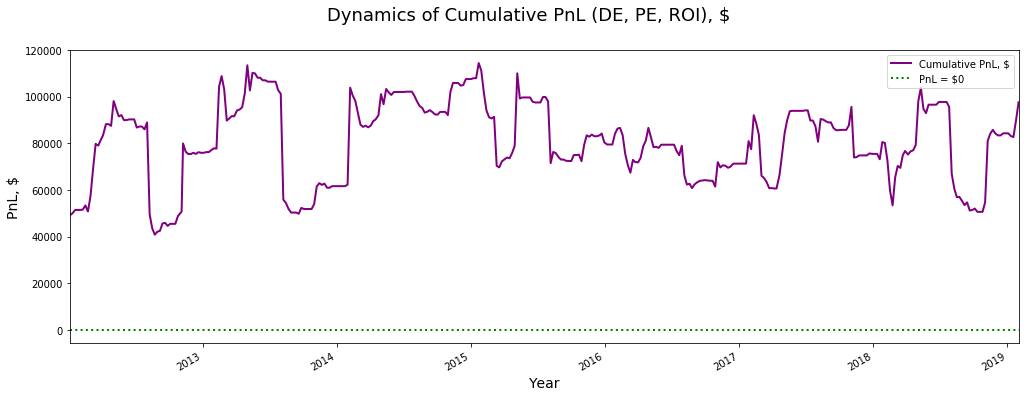

In [35]:
d = all_results_combo['DE_ratio,PE_ratio,ROI_ratio,Q=0.1,w=0.3/0.3/0.3']
d_df = pd.DataFrame(d)
d_df.rename(columns={0:'Date',1:'PnL'}, inplace=True)
d_df['Date'] = pd.to_datetime(d_df['Date'])
d_df['PnL_cum'] = d_df['PnL'].cumsum()
d_df.set_index('Date', inplace=True)

plt.figure(figsize=(17,6))
plt.suptitle('Dynamics of Cumulative PnL ({}), $'.format('DE, PE, ROI'), fontsize=18)
d_df['PnL_cum'].plot(label='Cumulative PnL, $', color='purple', linewidth=2)
plt.axhline(y=0, color='g', linestyle=':', linewidth=2, label='PnL = $0')
plt.xlabel('Year', fontsize=14)
plt.ylabel('PnL, $', fontsize=14)
plt.legend()
None

As we can see from the table above, **usage of combination of ratios* helps us to achieve much **better performance**. The highest PnL is obtained when we use combination of three ratios using **equal weights**.  Weights calculated as relative of cumulative PnL of each ratio also give good but a little bit worse reults in terms of profitability of the strategy. Thus, we can conclude that all ratios are equally important for making investment decisions.

Best results achieved by the quantile trading strategy:

- **Cumulative PnL for the whole investment period = \$98,060.50**;

- **Average Cumulative PnL for 1 year = \$14,008.60**;

- **Average weekly return = 0.26%**;

- **Annualized return = 14.68%**;

- **Sharpe Ratio modified = 0.0373** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account the OVERALL risk of our strategy is above the benchmark, and we have positive excess returns, i.e. in general we can just say that we have positive returns as benchmark is $0$. 

- **Sortino Ratio = 0.0396** with zero as a benchmark for its calculation (i.e. $r_b = 0$). It tells us that performance of our trading strategy taking into account ONLY the DOWNSIDE RISK of our strategy (measured by standard deviation of positions with negative returns) is above zero, and we have positive returns adjusted for downside risk. As Sortino Ratio is higher than Sharpe Ratio we can say that trading stretegy performs better in downturns taking into consideration underlying risk. 

Let us further take a look on securities investing in which has been the most profitable during the whole investment period for trading strategy implemented on equal-weighted combination of three ratios and using "best set of parameters".

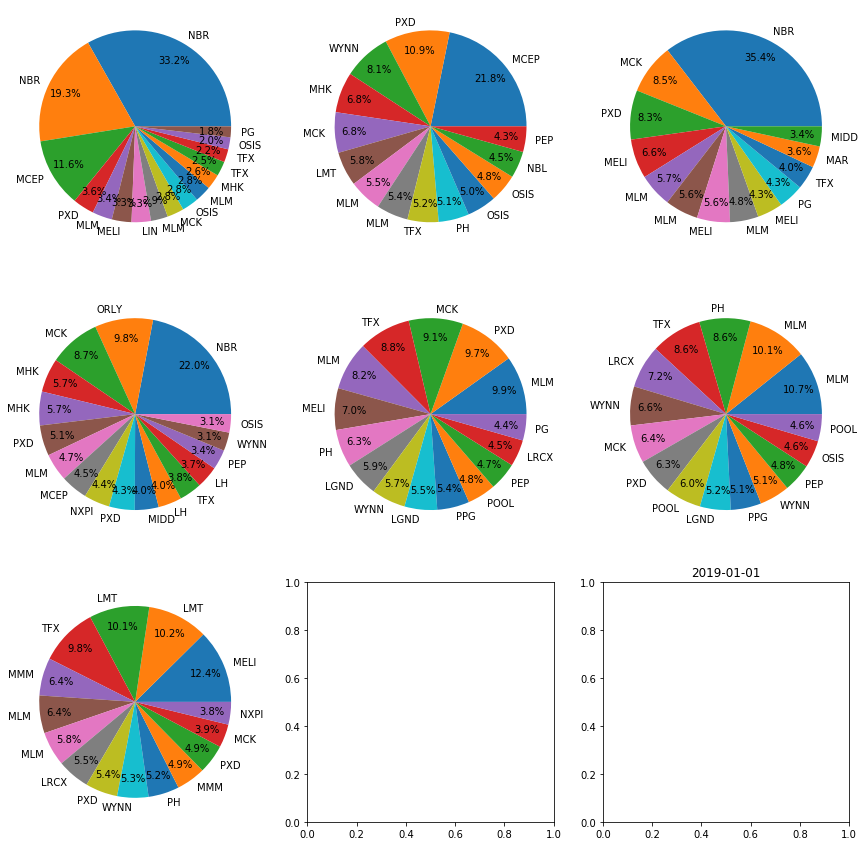

In [59]:
tot_pnl, year_pnl, week_ret, ann_ret, SR, SorR, df = \
    results(K, ['DE_ratio','PE_ratio','ROI_ratio'], False, 0.15, 0.3, 1, 1, [0.3,0.3,0.3], False)

years = ['2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01']

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

idx = 1
for row in ax:
    for col in row:
        y = years[idx]
        y_prev = years[idx-1]
        d = df[(df.index > y_prev) & (df.index < y) & (df['Size'] != 0)]
        d_ = d.sort_values('PnL', ascending=False)[:int(d.shape[0]*0.05)]
        patches, texts, autotexts = col.pie(d_['PnL'], labels=d_['Ticker'], autopct='%1.1f%%', pctdistance=0.8)
        my_circle = plt.Circle((0, 0), 0.55, color='white')
        plt.gca().add_artist(my_circle)
        plt.title(y)
        if idx!= 7:
            idx += 1
        else:
            break

plt.show()

In [67]:
print('From short to long: {}'.format(df[df['Idea']=='Close Short (> H_S) and Open Long (in Q_L)'].shape[0]))
print('From long to short: {}'.format(df[df['Idea']=='Close Long (< H_L) and Open Short (in Q_S)'].shape[0]))

From short to long: 143
From long to short: 0


As we can see from the pie chart above securities investment in which was the most profitable have not changed very much year-to-year. However, there was 143 cases when security "jumped" from "short part of portofolio" into "long part", however there were 0 cases of the opposite, i.e. no securities "jumped" from "long" into "short".